In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import torch
import torch.nn as nn
import torch.nn.functional as F

from metric import mape, mae

In [2]:
# data read
train_df = pd.read_csv('./data/train.csv', encoding='cp949')
test_df = pd.read_csv('./data/pre_test01.csv', encoding='cp949')
submission = pd.read_csv('./data/sample_submission.csv', encoding='cp949')

In [3]:
train_df

,num,date_time,elec_amount,temp,wind_speed,humidity,rainfall,sunshine,no_elec,sunlight_have
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0,0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0,0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0,0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1,1
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1,1
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1,1
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1,1


In [3]:
# 60건물 split

def df2d_to_array3d(df_2d):
    feature_size=df_2d.iloc[:,2:].shape[1]
    time_size=len(df_2d['date_time'].value_counts())
    sample_size=len(df_2d.num.value_counts())
    return df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])

In [4]:
train_df=df2d_to_array3d(train_df)
test_df=df2d_to_array3d(test_df)

### 제출용 dataset

In [13]:
valid_pred_array=np.zeros([60, 168])
for idx in range(train_df.shape[0]):
    x_series=train_df[idx, :, 0]
    model=auto_arima(x_series, start_p=0, start_q=0, max_p=15, max_d=3, max_q=15, trace=False)
    preds=model.predict(1, 168, typ='levels')
    valid_pred_array[idx, :]=preds


In [14]:
valid_pred_array

array([[8702.43633721, 8702.43633721, 8702.43633721, ..., 8702.43633721,
        8702.43633721, 8702.43633721],
       [1108.99068808, 1108.99068808, 1108.99068808, ..., 1108.99068808,
        1108.99068808, 1108.99068808],
       [3447.98240541, 3447.98240541, 3447.98240541, ..., 3447.98240541,
        3447.98240541, 3447.98240541],
       ...,
       [ 646.80223225,  646.80223225,  646.80223225, ...,  646.80223225,
         646.80223225,  646.80223225],
       [ 814.74420673,  814.74420673,  814.74420673, ...,  814.74420673,
         814.74420673,  814.74420673],
       [3154.80033351, 3154.80033351, 3154.80033351, ..., 3154.80033351,
        3154.80033351, 3154.80033351]])

In [17]:
submission['answer']=valid_pred_array.reshape([-1,1])
submission.to_csv('submission.csv', index=False)

### train data를 분할해서 예측 진행

In [25]:
train_df[0]

array([[8.179056e+03, 1.760000e+01, 2.500000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.135640e+03, 1.770000e+01, 2.900000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.107128e+03, 1.750000e+01, 3.200000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [8.730504e+03, 2.830000e+01, 1.100000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.725968e+03, 2.830000e+01, 2.400000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.705232e+03, 2.810000e+01, 2.300000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [5]:
# trn, tst - 8 : 2
tst_size = int(2040 * .1)
trn73, tst73 = train_df[0,:-tst_size,0], train_df[0,-tst_size:,0]

In [9]:
trn73.shape, tst73.shape

((1836,), (204,))

In [8]:
trn73[0]

8179.056

In [6]:
valid_pred_array=np.zeros([60, 680])
for idx in range(train_df.shape[0]):
    x_series=train_df[idx, :, 0]
    model=auto_arima(x_series, start_p=0, start_q=0, max_p=15, max_d=3, max_q=15, trace=False)
    preds=model.predict(1, 168, typ='levels')
    valid_pred_array[idx, :]=preds

KeyboardInterrupt: 

In [10]:
x, y = trn73, tst73
x.shape, y.shape

((1836,), (204,))

In [11]:
model=auto_arima(x, start_p=0, start_q=0, max_p=15, max_d=3, max_q=15, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18378.460, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18340.571, Time=0.09 sec


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18346.750, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18376.553, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=18333.027, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=18319.942, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=18321.856, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18321.873, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18327.496, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=18249.691, Time=1.95 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=18325.310, Time=0.67 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=18322.794, Time=2.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18323.521, Time=0.70 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=18323.313, Time=0.22 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=18326.002, Time=1.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=18249.054, Time=0.90 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=18319.959, Time=0.22

In [16]:
prd=model.predict(n_periods = len(y), typ='levels', dynamic=True)

In [19]:
type(x)

numpy.ndarray

In [12]:
prd = model.predict_in_sample(start=250,dynamic=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


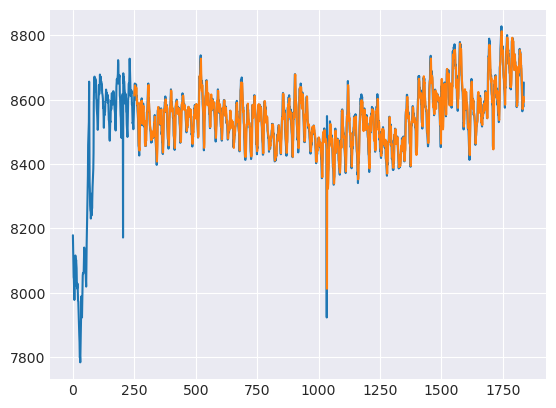

In [24]:
#("2020-06-01 01:00:00","2020-06-01 01:00:00", dynamic=False) # 미래를 예측할때는 dynamic을 사용하지 않아도 되지만 데이터 있는것(즉 tarin)을 할땐 사용해줘야한다 
plt.plot(x)
plt.plot(range(250, 1836),prd)
# plt.plot(prd)
plt.legend()
plt.show()

In [14]:
plt.title(f"AUTO_ARIMA, MAPE:{mape(prd, y):.4f}, MAE:{mae(prd, y):.4f}")
plt.plot(y, label="Target")
plt.plot(prd, label=f"Prediction")
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (1586,) (204,) 

In [18]:
a = torch.tensor([1, 2, 3], dtype=torch.float32)
a.shape

torch.Size([3])

In [19]:
a.numpy()

numpy.ndarray

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
print(torch.__version__)

2.1.2
